In [1]:
import torch
import torch.nn.functional as F

import pytorch3d
from pytorch3d.ops import sample_points_from_meshes
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import pytorch3d
from pytorch3d.ops import sample_points_from_meshes
# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Pointclouds

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.renderer.mesh.shading import (
    _apply_lighting,
)

# rendering components
from pytorch3d.renderer import (
    FoVOrthographicCameras, 
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    SoftPhongShader,
)

In [18]:
!wget https://get.station307.com/iF8tApEsmDe/teapot.obj


--2021-02-14 19:11:29--  https://get.station307.com/iF8tApEsmDe/teapot.obj
Resolving get.station307.com (get.station307.com)... 37.139.6.27
Connecting to get.station307.com (get.station307.com)|37.139.6.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [application/x-tgif]
Saving to: ‘teapot.obj’

teapot.obj          100%[===================>] 149.02K   447KB/s    in 0.3s    

2021-02-14 19:11:30 (447 KB/s) - ‘teapot.obj’ saved [152595/152595]



In [19]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ =  load_obj("./teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures =  TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)

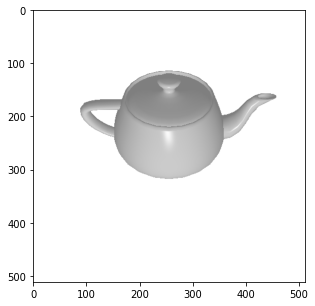

In [20]:
R, T = look_at_view_transform(100, 100, 10000)

# Select the viewpoint using spherical angles
distance = 3 # Distance from camera to the object
elevation = 50. # angle of elevation in degrees
azimuth = 0.0 # No rotation so the camera is positioned on the +Z axis

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
#R, T = look_at_view_transform(2.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=4, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 1.0, 3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)
images = renderer(teapot_mesh)
plt.figure(figsize=(5, 5))
plt.imshow(images[0, ..., :3].cpu().numpy());

In [21]:
n_points = 1000000
vertices, normals = sample_points_from_meshes(teapot_mesh, 
    n_points, return_normals=True)

vertices =  vertices[0].to(device)
normals =  normals[0].to(device)

rgb = torch.ones((n_points, 4), device=device) - 0.3

point_cloud = Pointclouds(points=[vertices], 
                          normals=[normals],
                          features=[rgb],
                         )


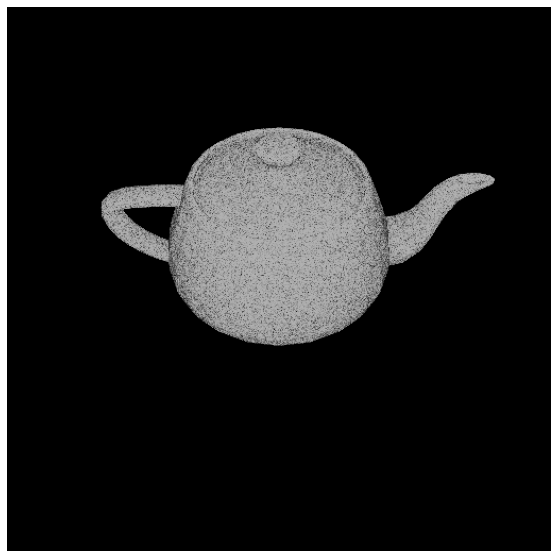

In [22]:
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, 
                                znear=0.1, zfar=1)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 4
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
points_renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)
images = points_renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [23]:
points_fragments =  points_renderer.rasterizer(point_cloud)

pix_to_point.shape torch.Size([1, 512, 512, 4])
idx torch.Size([1048576, 3])


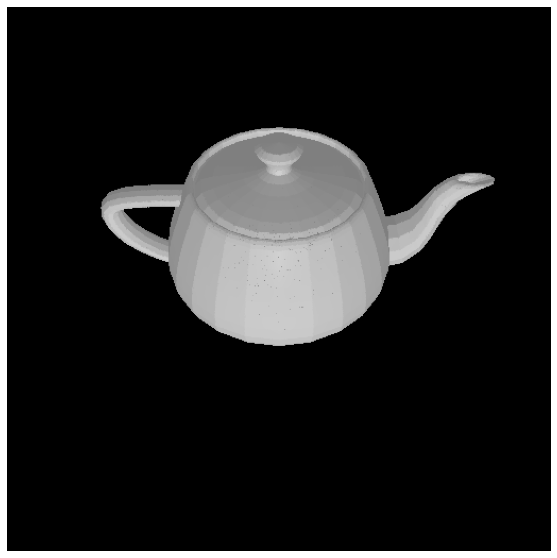

In [24]:
lights = renderer.shader.lights
materials = renderer.shader.materials

N, H, W, K = points_fragments.idx.shape

D = 4 # Fixed probably. what about alpha ??? 
pix_to_point  = points_fragments.idx
# Replace empty pixels in pix_to_face with 0 in order to interpolate.
mask = pix_to_point < 0
pix_to_point = pix_to_point.clone()
pix_to_point[mask] = 0

print('pix_to_point.shape',  pix_to_point.shape)

idx = pix_to_point.view(N * H * W * K, 1).expand(N * H * W * K, 3)
print('idx', idx.shape)



pixel_points_vals = point_cloud.points_packed().gather(0, idx.long()).view(N, H, W, K, 3)
pixel_points_vals.shape


pixel_normals_vals = point_cloud.normals_packed().gather(0, idx.long()).view(N, H, W, K, 3)
pixel_normals_vals.shape


ambient, diffuse, specular = _apply_lighting(
    pixel_points_vals, pixel_normals_vals, lights, cameras, materials
)

colors = (ambient + diffuse)+ specular

dist_mask = torch.where(points_fragments.dists != -1, 
                        points_fragments.dists,
                        torch.zeros_like(points_fragments.dists))

dist_mask_normed = F.normalize(dist_mask, p=1, dim=-1)
dist_mask.shape, dist_mask_normed.sum()

images = (dist_mask_normed[..., None] * colors).sum(dim=-2)


plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");